# 微博数据分析

数据包含微博 15 个影响力较大的新闻媒体 2020-1-20 到 2020-3-25 号微博正文，包含字段：微博id，微博正文，原始图片url，微博视频url，发布位置，发布时间，发布工具，点赞数，转发数，评论数


## 导入库/参数设置

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from snownlp import SnowNLP
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from clean_data import WeiboPreprocess 

In [52]:
start_date = "2020-1-20"
font_path = "../data/Microsoft YaHei Mono.ttf"
post_data_path = "../data/media_data"
stop_words_path = "../data/dictionary/stopwords.txt"
positive_words_path = "../data/dictionary/ntusd-positive.txt"
negative_words_path = "../data/dictionary/ntusd-negative.txt"

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

## 获取数据

In [ ]:
def get_data(file_path):
    total = pd.DataFrame()
    # read all xlsx files
    for root, dirs, files in tqdm(os.walk(file_path)):
        # merge all post
        for file in files:
            df = pd.read_csv(os.path.join(root, file))
            df.drop(columns=["微博id", "原始图片url", "微博视频url", "发布位置", "发布工具"], inplace=True)
            total = total.append(df)
    total.columns = ["post", "time", "like", "repost", "comment"]
    total["time"] = pd.to_datetime(total["time"]).dt.date
    total.sort_values("time", inplace=True)
    total.reset_index(drop=True, inplace=True)
    # concatenate posts by date
    # total = total.groupby("time")["post"].sum()
    return total

## 查看数据基本信息

In [ ]:
data = get_data(post_data_path)
data.shape

In [ ]:
data.info()

In [ ]:
data.head(50)

In [22]:
data.sort_values(by="time")

,post,time,like,repost,comment
0,无外售票！全城唯一！快抱带你去内部场提前5天看中国女排《夺冠》 原图,2020-01-20,16,5,7
401,【为什么突然增加了这么多确诊病例？】在武汉市卫健委19日凌晨举行媒体发布会上，湖北省医疗组专家、武汉市金银潭医院副院长、主任医师 黄朝林答记者问时说，“武汉市不明原因的病毒性肺炎被确定为新型...,2020-01-20,12,1,1
402,【中国中药协会被罚 曾授予鸿茅药业等企业荣誉称号】新京报快讯 据民政部消息，近日，民政部对中国中药协会作出警告并处没收违法所得20.729万元的行政处罚。经查，2019年3月，中国中药协会与中...,2020-01-20,14,1,3
403,【李克强主持召开国务院常务会议 进一步部署新型冠状病毒感染的肺炎疫情防控工作等】国务院总理李克强1月20日主持召开国务院常务会议，进一步部署新型冠状病毒感染的肺炎疫情防控工作，要求有力有效遏制...,2020-01-20,14,0,0
404,【截至20日18时 新型肺炎确诊病例217例疑似病例7例】近期，湖北省武汉市等多个地区发生新型冠状病毒感染的肺炎疫情。截至1月20日18时，境内累计报告新型冠状病毒感染的肺炎病例224例，其中...,2020-01-20,2,3,1
...,...,...,...,...,...
53671,【#意大利85岁医生准备重返一线#：我不害怕】3月22日，意大利媒体称受疫情影响该国医疗系统濒临崩溃，85岁退休名医表示他已准备好重新披挂上阵。Giampiero Giron是意大利威内托大区...,2020-03-24,1678,244,214
53670,【#奥运会推迟将致日本损失超3.2万亿#】据《今日美国》报道，据资深国际奥委会委员迪克·庞德当地时间23日透露，2020年东京奥运会将推迟至2021年。经济学家估算，#东京奥运会推迟#，访日游...,2020-03-24,2053,150,262
53669,【#野生天鹅守护被困水面伴侣# 场面感人】3月22日，河南郑州有一只野生天鹅被困，民警与林业局工作人员等人迅速赶到现场。这只天鹅的腿上绑有一条风筝线，有几十米长。在救助这只天鹅时，旁边还有一只...,2020-03-24,12389,668,621
53691,【跑步澳籍女子被警方带离社区 房屋已退租】北京朝阳区一澳籍进京女子不顾阻拦外出跑步，与社区防疫人员起争执引发热议一事有新进展。3月23日，一位知情人士告诉记者，该澳籍女子已于3月21日被警方带...,2020-03-24,3,3,3


## 每日发布微博数量分布图

In [37]:
# def get_user_data(file_path):
#     total = pd.DataFrame()
#     # read all xlsx files
#     for root, dirs, files in tqdm(os.walk(file_path)):
#         # merge all post
#         for file in files:
#             df = pd.read_csv(os.path.join(root, file))
#             df.drop(columns=["微博id", "原始图片url", "被转发微博原始图片url", "微博视频url", "发布位置", "发布工具"], inplace=True)
#             total = total.append(df)
#     total.columns = ["post", "is_original", "time", "like", "repost", "comment"]
#     total["time"] = pd.to_datetime(total["time"]).dt.date
#     total.sort_values("time", inplace=True)
#     total.reset_index(drop=True, inplace=True)
#     # concatenate posts by date
#     # total = total.groupby("time")["post"].sum()
#     return total
# user_data = get_user_data("../data/user_data")

501it [00:02, 195.06it/s]


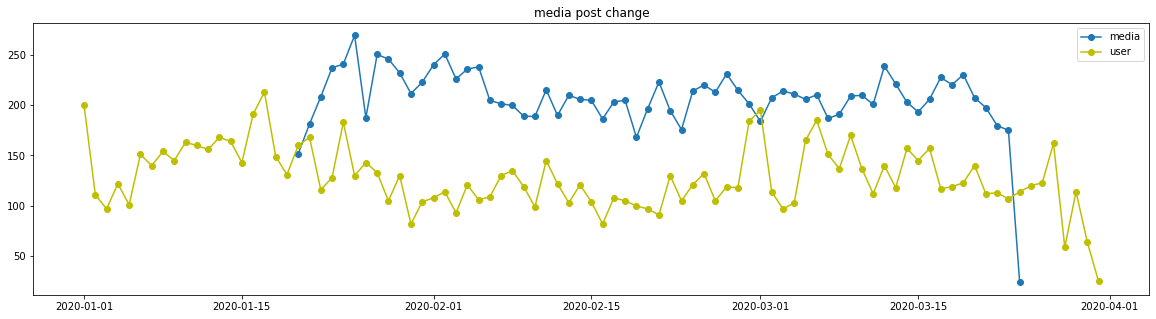

In [46]:
fig_media_user, ax_media_user = plt.subplots(figsize=(20, 5))
ax_media_user.set_title("media post change")
ax_media_user.plot(data.groupby("time").count()["post"]/4, "o-", label="media")
ax_media_user.plot(user_data.groupby("time").count()["post"], "yo-", label="user")
ax_media_user.legend(loc="best")
plt.savefig("../data/chart_pres_data/user_media_post_change.png", dpi=400, bbox_inches='tight')

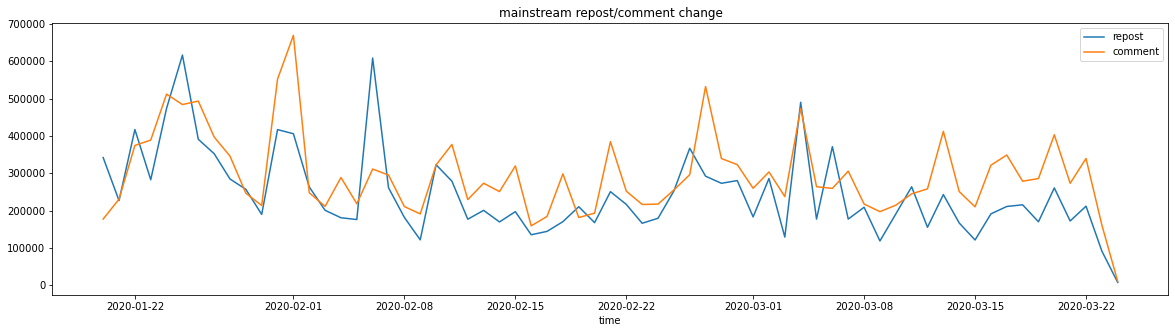

In [27]:
fig2, ax2 = plt.subplots(figsize=(20, 5))
ax2.set_title("mainstream repost/comment change")
df = data.groupby("time").sum()[["repost", "comment"]]
df.plot(ax=ax2, style='o-')
plt.grid()
plt.show()

## 微博正文内容预处理

In [47]:
# 文本清洗/分词
# data = data[~data["post"].str.contains("|".join(keyword_to_delete))]
data["post"] = data["post"].apply(lambda x: x.strip())
data = data[data["post"].str.len() > 3]
preprocess = WeiboPreprocess()
data["post"] = data["post"].apply(lambda x: preprocess.preprocess(x))
data = data[data["post"].str.len() > 3]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\const\AppData\Local\Temp\jieba.cache
Loading model cost 0.614 seconds.
Prefix dict has been built succesfully.


In [48]:
# get all kinds of vocabulary
def get_vocab(vocab_path):
    vacab = set()
    with open(vocab_path, encoding="utf-8") as f:
        vocab_list = [x.strip() for x in f.readlines()]
        vacab = set(vocab_list)
    return vacab

## 制作高频词词云

In [53]:
# load stop words
stopwords = get_vocab(stop_words_path)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dictionary/stop_words.txt'

In [ ]:
def gen_wordcloud(text, save_to_file):
    wc = WordCloud(font_path=font_path, width=1000, height=860, scale=2, max_words=100, stopwords=stopwords, background_color="white", collocations=False).generate(text)
    wc.to_file(save_to_file)
    plt.imshow(wc)
    plt.axis("off")

In [ ]:
# generate wordcloud by date
date = "2020-1-23"
gen_wordcloud(data.groupby("time")["post"].sum()[pd.to_datetime(date).date()], os.path.join("../data/wordcloud", "media_" + date + ".png"))

## 获取情绪高频词

In [ ]:
positive_words = get_vocab(positive_words_path)
negative_words = get_vocab(negative_words_path)

In [ ]:
from collections import Counter
postwords_list = data.groupby("time")["post"].sum()[pd.to_datetime("2020-1-20").date()].split()
pos_words_list = [word for word in postwords_list if word in positive_words]
neg_words_list = [word for word in postwords_list if word in negative_words]
pos_counter = Counter(pos_words_list)
pos_counter.most_common(10)

In [ ]:
neg_counter = Counter(neg_words_list)
neg_counter.most_common(10)